# Learning node embeddings with link-prediction

By Pavlin Poličar 28.8.2020

This notebook demonstrates how to learn node embeddings using a simple link-prediction model in the simplest way imaginable.

In [1]:
from math import comb

import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from openTSNE import TSNE

import torch
import torch.nn.functional as F

import torch_geometric as pyg
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import negative_sampling

import matplotlib.pyplot as plt
%matplotlib inline

## Download and load data

We will use a small graph of interactions between FDA-approved drugs from _Stanford Biomedical Network Dataset Collection_ (ChCh-Miner) for our simple example.

In [2]:
!mkdir -p data
!wget http://snap.stanford.edu/biodata/datasets/10001/files/ChCh-Miner_durgbank-chem-chem.tsv.gz -O data/ChCh-Miner_durgbank-chem-chem.tsv.gz
!yes | gunzip data/ChCh-Miner_durgbank-chem-chem.tsv.gz

--2020-08-29 07:47:01--  http://snap.stanford.edu/biodata/datasets/10001/files/ChCh-Miner_durgbank-chem-chem.tsv.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206802 (202K) [application/x-gzip]
Saving to: ‘data/ChCh-Miner_durgbank-chem-chem.tsv.gz’

data/ChCh-Miner_dur 100%[===================>] 201.96K   199KB/s    in 1.0s    

2020-08-29 07:47:03 (199 KB/s) - ‘data/ChCh-Miner_durgbank-chem-chem.tsv.gz’ saved [206802/206802]

gzip: data/ChCh-Miner_durgbank-chem-chem.tsv already exists;	not overwritten
yes: standard output: Broken pipe


_torch_geometric_ operates on edge lists of node indices (integers), but in the data set, drugs are encoded using an idenfier e.g. DB00966. So we will create a mapping from these IDs to ints.

In [3]:
drug_dict, edge_index = {}, []
drug_index = 0  # we will use this to assign numbers to drugs

with open("data/ChCh-Miner_durgbank-chem-chem.tsv") as f:
    for line in f:
        line = line.rstrip()
        d1, d2 = line.split("\t")
        
        if d1 not in drug_dict:
            drug_dict[d1] = drug_index
            drug_index += 1
        if d2 not in drug_dict:
            drug_dict[d2] = drug_index
            drug_index += 1
        
        edge_index.append([drug_dict[d1], drug_dict[d2]])

print(f"{len(edge_index):,} interactions")

48,514 interactions


In [4]:
edge_index = torch.LongTensor(edge_index).T
edge_index

tensor([[   0,    2,    4,  ..., 1057,  361,  455],
        [   1,    3,    5,  ...,  359,  626,  269]])

We now has something that _torch_geometric_ considers a graph.

### Examine graph

In [5]:
print("Sparsity: %.2f" % (edge_index.size(1) / comb(len(edge_index[0].unique()), 2)))

Sparsity: 0.06


In [6]:
pyg.utils.is_undirected(edge_index)

False

In [7]:
edge_index = pyg.utils.to_undirected(edge_index)

In [8]:
print(f"{len(edge_index.unique()):,} nodes")

1,514 nodes


### Extract LCC

Many graph-based learning techniques cannot operate on disconnected graphs, so it is standard practice to operate on the largest connected component (LCC). The easiest way to exctract the LCC is to use _networkx_, a popular pure Python library for network analysis.

In [9]:
data = pyg.data.Data(edge_index=edge_index)
nx_data = pyg.utils.to_networkx(data, to_undirected=True)
nx_data

In [10]:
connected_components = list(nx.connected_components(nx_data))
len(connected_components)
print(f"Graph contains {len(connected_components)} connected components")

Graph contains 3 connected components


In [11]:
lcc_nodes = max(connected_components, key=len)
lcc = nx_data.subgraph(lcc_nodes)
print(f"{lcc.number_of_nodes():,} nodes in LCC")

1,510 nodes in LCC


We've now extracted the LCC of our graph and lost 4 nodes. Let's convert this back into a torch edge list, so we can start fitting our models.

In [12]:
edge_index = pyg.utils.from_networkx(lcc).edge_index
edge_index

tensor([[   0,    0,    0,  ..., 1507, 1508, 1509],
        [   1,    2,    9,  ..., 1011,  346,   45]])

## Link prediction

In this simple example, we want to learn node embeddings. One simple way to achieve this is to perform link-prediction i.e. our model will learn to predict whether or not an edge exists between two nodes.

### Prepare data set

As in any machine learning task, we split our data set into a training and validation set. In _torch_geometric_, it is easiest to define boolean masks to indicate which edges belong into each set. Why not use integer indices? Because we can easily attach boolean masks to a _torch_geometric_ `pyg.data.Data` object, which will be indexed properly during mini-batching. Indexing the masks is only possible if their shape matches that of the `edge_index`, so a boolean mask is the way to go.

In [13]:
indices = torch.arange(edge_index.shape[1])
train_idx, val_idx = train_test_split(indices, test_size=0.01)
train_mask, val_mask = torch.zeros_like(indices).bool(), torch.zeros_like(indices).bool()
train_mask[train_idx] = 1
val_mask[val_idx] = 1
train_mask, val_mask

(tensor([True, True, True,  ..., True, True, True]),
 tensor([False, False, False,  ..., False, False, False]))

Because our nodes have no additional features, we use a one-hot encoding as features to our model. Obviously, creating a dense identity matrix is very memory-inefficient, and we will quickly run out of memory when working with larger graphs.

In [14]:
num_nodes = lcc.number_of_nodes()
x = torch.sparse.FloatTensor(
    indices=torch.stack([torch.arange(num_nodes), torch.arange(num_nodes)]),
    values=torch.ones(num_nodes),
)

data = pyg.data.Data(edge_index=edge_index, x=x, train_mask=train_mask, val_mask=val_mask)
data

Data(edge_index=[2, 97024], train_mask=[97024], val_mask=[97024], x=[1510, 1510])

To check how well our model is doing, we want to validate performance using a set of real, existing edges, as well as an equal number of non-existent edges. To get these non-existent edges, we perform negative sampling, and attach these to our data object.

In [15]:
data.val_neg_edge_index = negative_sampling(data.edge_index, num_neg_samples=data.val_mask.sum())

### Prepare model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
class Encoder(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

### Batch learning

We are now ready to fit our model. We first look at batch learning, where the model will look at all the available data, i.e. the entire graph, before performing a parameter update. This is fine for smaller graphs which can fit into memory.

In [18]:
model = GAE(Encoder(data.num_features, hidden_dim=32, out_dim=16)).to(device)
model

GAE(
  (encoder): Encoder(
    (conv1): GCNConv(1510, 32)
    (conv2): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
training_losses, validation_losses, val_auc, val_ap = [], [], [], []

for epoch in range(400):
    model.train()
    optimizer.zero_grad()
    
    # train_pos_edge_index contains the true edges, i.e. edges that exist, in the training set
    train_pos_edge_index = data.edge_index[:, data.train_mask].to(device)
    x = data.x.to(device)
    
    # z holds the node embeddings
    z = model.encode(x, train_pos_edge_index)
    # while the link prediction is performed inside this handy model.recon_loss function
    loss = model.recon_loss(z, train_pos_edge_index)
    training_loss = loss.item()
    loss.backward()
    optimizer.step()

    model.eval()
    
    # To validate our model, we first compute node embeddings for each node using the training
    # set edges.
    train_pos_edge_index = data.edge_index[:, data.train_mask].to(device)
    # Our model's predictions will then be checked against the true, existing validation edges
    # stored in val_pos_edge_index
    val_pos_edge_index = data.edge_index[:, data.val_mask].to(device)

    with torch.no_grad():
        z = model.encode(data.x.to(device), train_pos_edge_index)
        validation_loss = model.recon_loss(z, val_pos_edge_index).item()
    
    auc, ap = model.test(z, val_pos_edge_index, data.val_neg_edge_index)
    
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)
    val_auc.append(auc)
    val_ap.append(ap)
    
    if (epoch + 1) % 20 == 0:
        print("Epoch: {:03d}, Training loss: {:.4f}, Validation loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}".format(
            epoch + 1, training_loss, validation_loss, auc, ap))

Epoch: 020, Training loss: 1.1263, Validation loss: 1.1555, AUC: 0.8421, AP: 0.8405
Epoch: 040, Training loss: 1.0959, Validation loss: 1.1318, AUC: 0.8569, AP: 0.8551
Epoch: 060, Training loss: 1.0143, Validation loss: 1.0481, AUC: 0.8968, AP: 0.8995
Epoch: 080, Training loss: 0.9974, Validation loss: 1.0417, AUC: 0.8979, AP: 0.9042
Epoch: 100, Training loss: 0.9915, Validation loss: 1.0661, AUC: 0.9043, AP: 0.9088
Epoch: 120, Training loss: 0.9720, Validation loss: 1.0501, AUC: 0.9162, AP: 0.9191
Epoch: 140, Training loss: 0.9518, Validation loss: 1.0316, AUC: 0.9254, AP: 0.9262
Epoch: 160, Training loss: 0.9402, Validation loss: 1.0389, AUC: 0.9292, AP: 0.9301
Epoch: 180, Training loss: 0.9345, Validation loss: 1.0162, AUC: 0.9317, AP: 0.9332
Epoch: 200, Training loss: 0.9254, Validation loss: 1.0036, AUC: 0.9350, AP: 0.9355
Epoch: 220, Training loss: 0.9104, Validation loss: 0.9940, AUC: 0.9395, AP: 0.9390
Epoch: 240, Training loss: 0.8882, Validation loss: 1.0106, AUC: 0.9447, AP:

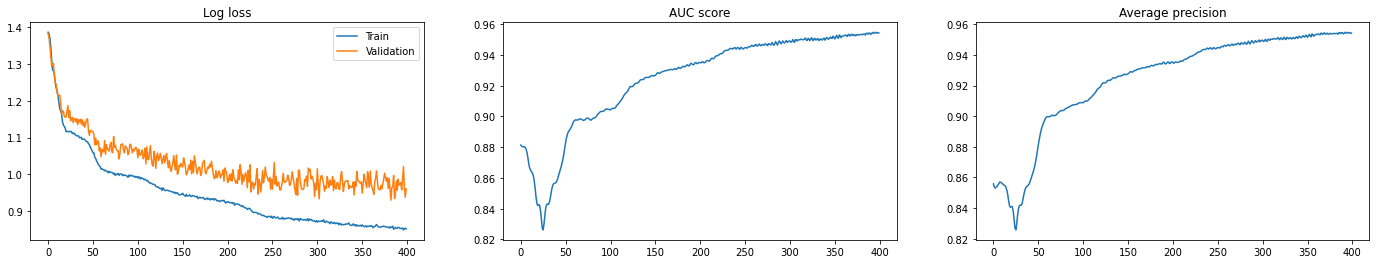

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 4))

ax[0].set_title("Log loss")
ax[0].plot(training_losses, label="Train")
ax[0].plot(validation_losses, label="Validation")
ax[0].legend()

ax[1].set_title("AUC score")
ax[1].plot(val_auc)

ax[2].set_title("Average precision")
ax[2].plot(val_ap)

#### Inspect node embeddings

Now that our model is trained, we can visualize the node embeddings. We decided that our node embeddings are 16-dimensional. We can easily convert this to a 2D visualization using any visualization algorithm. We will not go into any interpretation here, as the point of the notebook is to demonstrate how to actually fit these models.

In [22]:
embedding = z.cpu().detach().numpy()
embedding

array([[ 1.203167  ,  0.37856695,  0.07547071, ..., -0.3577132 ,
        -0.5094402 , -0.57982814],
       [ 0.6004847 ,  0.26399976, -0.08310493, ...,  0.14630665,
        -0.38418633, -0.19063061],
       [ 0.5789565 ,  0.19155788,  0.46717912, ...,  0.1252377 ,
        -0.35907042, -0.13721931],
       ...,
       [-0.20392296,  0.0724631 , -0.09172509, ...,  0.21845216,
         0.2576127 ,  0.19349602],
       [-0.0789538 , -0.00251227,  0.0212366 , ...,  0.18989109,
         0.11339691,  0.11686186],
       [-0.22405833,  0.02342206, -0.11180983, ...,  0.23680493,
         0.2487401 ,  0.19205548]], dtype=float32)

In [23]:
tsne_embedding = TSNE(exaggeration=2, n_jobs=4).fit(embedding)

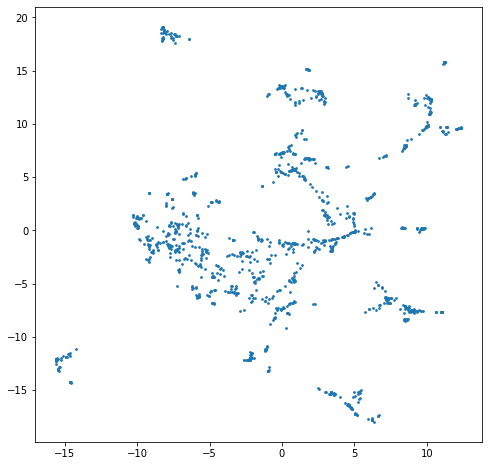

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=3)

### Learning with graphSAINT mini-batches

Once we start working with graphs which can no longer fit into memory, a batch learning approach will no longer work. In computer vision, mini-batching is the standard way to learn deep models, where the training set, containing millions of images is split into thousands of _mini-batches_ containing e.g. 64 images. After the model sees these 64 images, it performs a parameter update. Obviously, such a small number of images is insufficient to estimate the true gradient, which is why training and validation losses here are very noisy.

In graph neural networks, when doing link prediction on a single, large graph, extracting mini-batches is not as straight-forward. Here, we will make use of graphSAINT, a graph sampler which creates small subgraphs of our large network, which we can then use to fit the model.

In [25]:
model = GAE(Encoder(data.num_features, hidden_dim=32, out_dim=16)).to(device)
model

GAE(
  (encoder): Encoder(
    (conv1): GCNConv(1510, 32)
    (conv2): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

For some reason, _torch_geometric_ does not support sparse tensor indexing. Remember that our node features are a large, sparse, identity matrix, so this is something that we need to work. The following code below simply monkey-patches the graphSAINT sampler so that sparse COO tensor indexing works properly. This fix  will likley need to be updated with newer _torch_geometric_ versions, and hopefully, this will soon be supported by _torch_geometric_ itself.

In [27]:
from torch_geometric.data import GraphSAINTSampler


def mcollate(self, data_list):
    assert len(data_list) == 1
    node_idx, adj_t = data_list[0]

    data = self.data.__class__()
    data.num_nodes = node_idx.size(0)
    col, row, edge_idx = adj_t.coo()
    data.edge_index = torch.stack([row, col], dim=0)

    for key, item in self.data:
        if item.size(0) == self.N:
            # Changes
            if item.layout == torch.sparse_coo:
                item = item.coalesce()

                indices = item.indices()
                new_indices = indices[:, node_idx]
                new_indices[0] = torch.arange(len(node_idx))

                values = item.values()

                data[key] = torch.sparse.FloatTensor(
                    new_indices, values[node_idx], size=torch.Size([len(node_idx), item.size(1)])
                )
            # End changes
            else:
                data[key] = item[node_idx]
        elif item.size(0) == self.E:
            data[key] = item[edge_idx]
        else:
            data[key] = item

    if self.sample_coverage > 0:
        data.node_norm = self.node_norm[node_idx]
        data.edge_norm = self.edge_norm[edge_idx]

    return data


GraphSAINTSampler.__collate__ = mcollate

The graphSAINT sampler needs three key parameters, which can be interpreted in the following way. `batch_size` determines how large our induced subgraphs will be, `walk_length` should be set to the depth of the model. In our case, our model is a two-layer GCN, so we set walk_lenght to 2. `num_steps` determines how many subgraphs will be generated at each epoch.

In [28]:
from torch_geometric.data import GraphSAINTRandomWalkSampler

loader = GraphSAINTRandomWalkSampler(
    data, batch_size=64, walk_length=2, num_steps=32,
)

In [29]:
training_losses, validation_losses, val_auc, val_ap = [], [], [], []

for epoch in range(400):
    model.train()
    
    training_loss = []
    # Instead of operating on the entire graph, we can now iterate over the loader to obtain mini-batches
    for batch in loader:
        optimizer.zero_grad()
        
        # All parameter updates are now performed on `batch` instead of `data`
        train_pos_edge_index = batch.edge_index[:, batch.train_mask].to(device)
        x_batch = batch.x.to(device)

        z = model.encode(x_batch, train_pos_edge_index)
        loss = model.recon_loss(z, train_pos_edge_index)
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.mean(training_loss)

    model.eval()

    train_pos_edge_index = data.edge_index[:, data.train_mask].to(device)
    val_pos_edge_index = data.edge_index[:, data.val_mask].to(device)

    with torch.no_grad():
        # For validation, we still use the entire graph to generate node embeddings. Clearly, this is
        # problematic for larger graphs, as the entire graph will not fit into memory. The easiest solution
        # to this is to simply evaluate the entire graph on the CPU instead of the GPU (if working on the GPU)
        # Move the model and data to the CPU by calling the .cpu() method on the required variables.
        z = model.encode(data.x.to(device), train_pos_edge_index)
        validation_loss = model.recon_loss(z, val_pos_edge_index).item()

    auc, ap = model.test(z, val_pos_edge_index, data.val_neg_edge_index)
    
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)
    val_auc.append(auc)
    val_ap.append(ap)
    
    if (epoch + 1) % 20 == 0:
        print("Epoch: {:03d}, Training loss: {:.4f}, Validation loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}".format(
            epoch + 1, training_loss, validation_loss, auc, ap))

Epoch: 020, Training loss: 1.0774, Validation loss: 1.1253, AUC: 0.8257, AP: 0.8511
Epoch: 040, Training loss: 1.0328, Validation loss: 1.1132, AUC: 0.8463, AP: 0.8611
Epoch: 060, Training loss: 1.0025, Validation loss: 1.1161, AUC: 0.8556, AP: 0.8648
Epoch: 080, Training loss: 1.0050, Validation loss: 1.0649, AUC: 0.8781, AP: 0.8869
Epoch: 100, Training loss: 0.9882, Validation loss: 1.0914, AUC: 0.8757, AP: 0.8837
Epoch: 120, Training loss: 0.9866, Validation loss: 1.0732, AUC: 0.8761, AP: 0.8878
Epoch: 140, Training loss: 0.9907, Validation loss: 1.1378, AUC: 0.8389, AP: 0.8538
Epoch: 160, Training loss: 0.9590, Validation loss: 1.0949, AUC: 0.8781, AP: 0.8880
Epoch: 180, Training loss: 0.9666, Validation loss: 1.0745, AUC: 0.8780, AP: 0.8882
Epoch: 200, Training loss: 0.9688, Validation loss: 1.0542, AUC: 0.8881, AP: 0.8968
Epoch: 220, Training loss: 0.9661, Validation loss: 1.1207, AUC: 0.8653, AP: 0.8781
Epoch: 240, Training loss: 0.9549, Validation loss: 1.1021, AUC: 0.8742, AP:

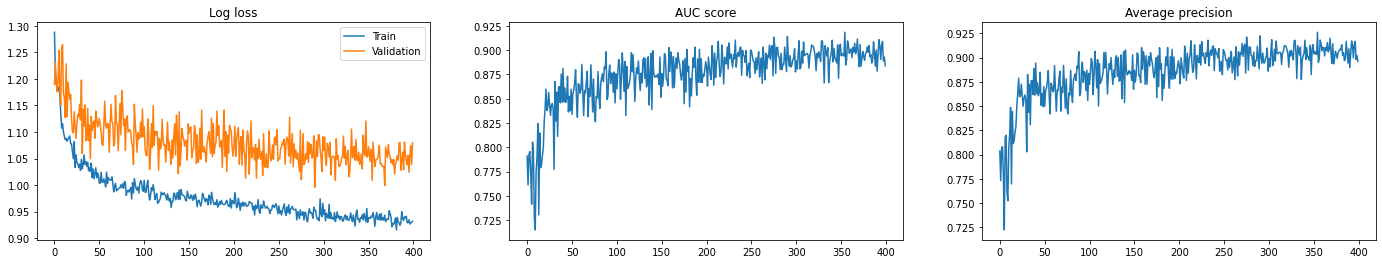

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 4))

ax[0].set_title("Log loss")
ax[0].plot(training_losses, label="Train")
ax[0].plot(validation_losses, label="Validation")
ax[0].legend()

ax[1].set_title("AUC score")
ax[1].plot(val_auc)

ax[2].set_title("Average precision")
ax[2].plot(val_ap)

Notice that since we are using mini-batches to evaluate gradients, the losses are considerably more noisy. This should feel very familliar to things we see in other domains of deep learning.

#### Inspect node embeddings

In [31]:
embedding = z.cpu().detach().numpy()
embedding

array([[-0.7586303 , -0.2735108 ,  0.2342171 , ..., -0.14178416,
        -1.0155852 , -0.10608599],
       [-0.6547871 , -0.02414304, -0.06818062, ..., -0.26064652,
        -0.7518048 , -0.18309817],
       [-0.19947338, -0.26289415, -0.12712541, ..., -0.3194538 ,
        -0.50377893,  0.15859678],
       ...,
       [-0.6561849 ,  0.52101064, -0.49592626, ..., -0.33382812,
         0.35999662, -0.33908796],
       [-0.6494651 ,  0.5235026 , -0.40009382, ..., -0.39456436,
         0.39140666, -0.52278054],
       [-0.49076712,  0.5546827 , -0.22774664, ..., -0.253722  ,
         0.4534623 , -0.4508762 ]], dtype=float32)

In [32]:
tsne_embedding = TSNE(exaggeration=2, n_jobs=4).fit(embedding)

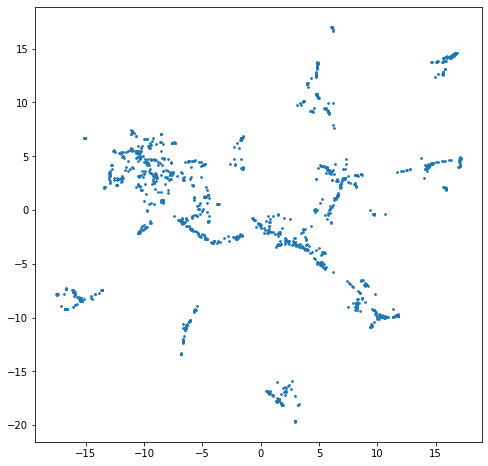

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=3)

We again inspect the embeddings, and we see that the general topology of the t-SNE visualization mostly resembles the visualization obtained from batch learning.